## Scenario B: Bid Pricing & Win-Rate

Commercial janitorial and day porter bids are highly price-competitive.
My goal is to identify bid pricing that maximizes expected profit while maintaining a high win probability and meeting a 10% minimum margin requirement.

This notebook demonstrates a technical prototype pipeline including:
- Synthetic historical bid data creation
- Synthetic proposal text & regex-based feature extraction
- Logistic win-rate modeling + probability calibration
- Expected profit optimization across candidate prices
- Guardrails to enforce pricing minimum 10% margin threshold

This prototype simulates realistic pricing dynamics based on business intuition and constraints.

### Pipeline Flow Diagram

In [1]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, json, random
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, brier_score_loss
from scipy.optimize import minimize_scalar

np.random.seed(42)

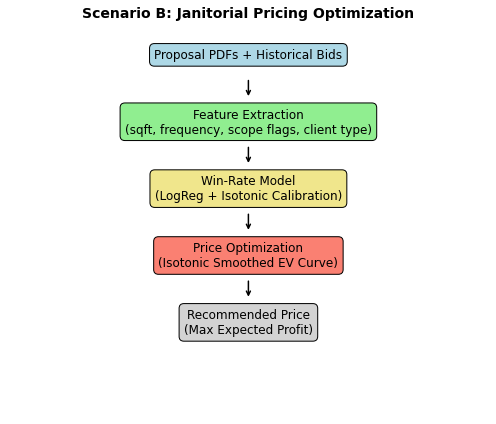

In [2]:
fig, ax = plt.subplots(figsize=(7,6))
ax.axis('off')

# Define vertical positions
boxes = [
    ("Proposal PDFs + Historical Bids", 0.92, "lightblue"),
    ("Feature Extraction\n(sqft, frequency, scope flags, client type)", 0.75, "lightgreen"),
    ("Win-Rate Model\n(LogReg + Isotonic Calibration)", 0.58, "khaki"),
    ("Price Optimization\n(Isotonic Smoothed EV Curve)", 0.41, "salmon"),
    ("Recommended Price\n(Max Expected Profit)", 0.24, "lightgray")
]

# Draw boxes
for text, y, color in boxes:
    ax.text(0.5, y, text, ha='center', va='center',
            fontsize=12, bbox=dict(boxstyle="round,pad=0.4", fc=color))

# Arrows
arrow_links = [
    (0.92, 0.75),
    (0.75, 0.58),
    (0.58, 0.41),
    (0.41, 0.24),
]

for y1, y2 in arrow_links:
    mid = (y1 + y2) / 2
    ax.annotate("",
                xy=(0.5, mid - 0.025),
                xytext=(0.5, mid + 0.025),
                arrowprops=dict(arrowstyle="->", lw=1.5))

plt.title("Scenario B: Janitorial Pricing Optimization", fontsize=14, weight='bold')
plt.tight_layout()
plt.savefig("docs/flowchart.png", dpi=300)
plt.show()

### Assumptions & Synthetic Data Setup

- Only non-union scenarios.
- Minimum 10% margin floor applies.
- Corporate office cleaning with buildings between 3k–30k sqft
- Price per sqft range: \$0.05 - \$0.20
- Cost per sqft range: \$0.035 - \$0.15
- Proposal text is unstructured PDFs.
- Historical data includes 1,200 synthetic bids for prototyping, features  including: client type, square footage, cost, submitted price, price per sqft, year, timestamp, award flag.
- Success metrics: maximize revenue while keeping margin >= 10% and reasonable win probability.

In [3]:
# Generate Synthetic Bid Data

# Number of historical bids used for prototyping
n_bids = 1200

# Realistic operating ranges for commercial office cleaning
sqft_min, sqft_max = 3000, 30000
price_per_sqft_min, price_per_sqft_max = 0.05, 0.20
cost_per_sqft_min, cost_per_sqft_max = 0.035, 0.15

# Client industry categories
client_types = ['finance','tech','legal','consulting','real_estate']

rows = []
start_date = datetime(2015,1,1)
for i in range(n_bids):
    # Square footage drawn from exponential distribution
    sqft = int(np.random.exponential(scale=7000)) + sqft_min
    sqft = max(sqft_min, min(sqft, sqft_max))
    
    client_type = random.choice(client_types)
    
    # Generate cost & submitted price per sqft independently
    cost_per_sqft = np.random.uniform(cost_per_sqft_min, cost_per_sqft_max)
    cost = cost_per_sqft * sqft
    price_per_sqft = np.random.uniform(price_per_sqft_min, price_per_sqft_max)
    if client_type == 'finance':
        price_per_sqft *= np.random.uniform(1.05, 1.2)
    elif client_type == 'tech':
        price_per_sqft *= np.random.uniform(0.9, 1.1)

    submitted_price = price_per_sqft * sqft
    
    # Randomize submission timing across 10 years
    ts = start_date + timedelta(days=random.randint(0, 365*10))
    
    # Synthetic Win Probability
    # Pricing sensitivity simulated through price ratio vs. benchmark
    price_ratio = price_per_sqft / 0.12
    # Industry factor influences how sensitive a client is to price
    client_factor = {'finance':0.05, 'tech':0.10, 'legal':0.03, 'consulting':0.06, 'real_estate':0.08}[client_type]
    
    # Logistic-style map to keep probs in (0,1)
    #base_prob = 0.45 - 0.8 * (price_ratio - 1) * 0.5 + client_factor
    base_prob = 0.5 - 1.2 * (price_ratio - 1) + client_factor
    base_prob = 1 / (1 + np.exp(-(base_prob - 0.5)*4))
    
    # Add realism by noise + clipping for boundaries
    final_prob = np.clip(base_prob + np.random.normal(0,0.06), 0.01, 0.98)
    award_flag = int(np.random.rand() < final_prob)
    
    rows.append({
        'bid_id': f'BID_{i:04d}',
        'client_id': f'C_{random.randint(1,300):03d}',
        'client_type': client_type,
        'sqft': sqft,
        'cost': round(cost,2),
        'submitted_price': round(submitted_price,2),
        'price_per_sqft': round(price_per_sqft,4),
        'year': ts.year,
        'timestamp': ts.strftime("%Y-%m-%d"),
        'award_flag': award_flag
    })

df_bids = pd.DataFrame(rows)
print("Synthetic bids:", df_bids.shape)

Synthetic bids: (1200, 10)


In [4]:
df_bids.head()

,bid_id,client_id,client_type,sqft,cost,submitted_price,price_per_sqft,year,timestamp,award_flag
0,BID_0000,C_244,tech,6284,906.98,1023.99,0.1630,2017,2017-02-25,1
1,BID_0001,C_171,finance,17078,1778.30,2809.40,0.1645,2021,2021-05-19,0
2,BID_0002,C_012,real_estate,15505,921.29,1198.13,0.0773,2019,2019-07-26,1
3,BID_0003,C_049,legal,6958,476.56,986.49,0.1418,2019,2019-05-23,1
4,BID_0004,C_287,finance,5418,417.90,749.18,0.1383,2017,2017-12-25,0


### Proposal Text Extraction (Unstructured → Structured)

Simulating proposal narratives from PDFs and extract key features:

In [5]:
# Example proposal text samples representing OCR-extracted narrative content
sample_texts = [
    "Scope of Work: Daily janitorial services for 15,000 sqft corporate office. Includes restrooms, lobby, kitchen pantry, and conference rooms. Frequency: 5 days/week. Contract length: 12 months. Special requirements: after-hours cleaning for events twice a month.",
    "Proposal: Weekly cleaning for 8,000 sqft office. Tasks include floor care, trash removal and restroom maintenance. Frequency: 3x per week. Client expects deep-clean quarterly.",
    "Scope: Office complex 45,000 sqft with multiple floors. Services: day porter + daily cleaning for common areas, windows cleaning monthly. Requires background-checked staff.",
    "Request: One-time deep clean for 10,000 sqft after renovation. Scope: floor stripping/waxing, dust removal. Not recurring.",
    "Proposal: 60,000 sqft headquarters. Daily daytime porter and nightly janitorial services. Includes floor care, kitchen areas and carpet cleaning. Contract length 24 months.",
    "Scope: 7,500 sqft small office suite. Frequency: 2 days/week. No specialized services.",
    "Proposal: 25,000 sqft, 5 days/week, requires green cleaning supplies and floor waxing every 3 months. Client requests certificate of insurance.",
    "RFP narrative: 12,000 sqft, high-security financial firm, requires employee background checks and weekend cleaning. Frequency: 6 days/week.",
    "Request: 30,000 sqft, including restrooms, kitchenettes, and conference centers. Frequency daily. Special cleaning for server rooms require equipment handling.",
    "Proposal: 9,000 sqft law firm office. Requires discreet after-hours cleaning. Frequency: nightly.",
    "RFP: 18,000 sqft tech firm with frequent events; needs flexible schedule and day porter services on weekdays.",
    "Proposal: 20,000 sqft retail-office mix, nightly cleaning and weekly deep cleaning of all bathrooms and kitchens."
]

In [6]:
# Extraction functions
import re

# Extract sqft numbers that appear next to "sqft" tokens
def extract_sqft(text):
    m = re.search(r'([0-9]{1,3}(?:,[0-9]{3})+|[0-9]{4,6})\s*(sqf|sqft|sq ft|square feet|square footage)', text, re.I)
    if m:
        val = m.group(1).replace(",", "")
        return int(val)
    return None

# Extract cleaning frequency if mentioned
def extract_frequency(text):
    text_l = text.lower()
    if 'daily' in text_l or 'nightly' in text_l: return 'daily'
    if '5 days/week' in text_l or '5 days' in text_l: return '5_per_week'
    if '3x per week' in text_l or '3 times' in text_l or '3x' in text_l: return '3_per_week'
    if 'weekly' in text_l: return 'weekly'
    m = re.search(r'(\d)\s*days?/week', text_l)
    if m: return f"{m.group(1)}_per_week"
    return None

# Extract presence of key scope indicators
def extract_scope_flags(text):
    text_l = text.lower()
    flags = {}
    flags['restrooms'] = any(k in text_l for k in ['restroom','bathroom','toilet'])
    flags['kitchen'] = any(k in text_l for k in ['kitchen','pantry'])
    flags['conference'] = any(k in text_l for k in ['conference','meeting room'])
    flags['windows'] = any(k in text_l for k in ['window','windows'])
    flags['floor_wax'] = any(k in text_l for k in ['wax','floor waxing','stripping'])
    return flags

# Apply extraction to simulated sample proposals
extracted_data = []
for i, txt in enumerate(sample_texts):
    data = {
        "proposal_id": i+1,
        "sqft_prop": extract_sqft(txt),
        "frequency": extract_frequency(txt)
    }
    data.update(extract_scope_flags(txt))
    extracted_data.append(data)

df_proposals = pd.DataFrame(extracted_data)

In [7]:
df_proposals.head()

,proposal_id,sqft_prop,frequency,restrooms,kitchen,conference,windows,floor_wax
0,1,15000,daily,True,True,True,False,False
1,2,8000,3_per_week,True,False,False,False,False
2,3,45000,daily,False,False,False,True,False
3,4,10000,None,False,False,False,False,True
4,5,60000,daily,False,True,False,False,False


### Merge Structured & Text-Based Features

Matching text proposals to bids using nearest sqft which is a good proxy for similarity.

In [8]:
# Merge bids with proposals using nearest sqft
df_bids_sorted = df_bids.sort_values('sqft').reset_index(drop=True)
df_proposals_sorted = df_proposals.sort_values('sqft_prop').reset_index(drop=True)

df = pd.merge_asof(df_bids_sorted, df_proposals_sorted,
                   left_on='sqft', right_on='sqft_prop',
                   direction='nearest')

In [9]:
df.head()

,bid_id,client_id,client_type,sqft,cost,submitted_price,price_per_sqft,year,timestamp,award_flag,proposal_id,sqft_prop,frequency,restrooms,kitchen,conference,windows,floor_wax
0,BID_0724,C_221,real_estate,3007,199.29,248.63,0.0827,2015,2015-02-16,1,6,7500,2_per_week,False,False,False,False,False
1,BID_0475,C_047,finance,3009,209.06,528.96,0.1758,2016,2016-01-09,0,6,7500,2_per_week,False,False,False,False,False
2,BID_0509,C_256,legal,3010,357.81,587.03,0.1950,2016,2016-07-08,0,6,7500,2_per_week,False,False,False,False,False
3,BID_1188,C_025,consulting,3026,188.78,577.26,0.1908,2021,2021-03-23,0,6,7500,2_per_week,False,False,False,False,False
4,BID_0773,C_111,tech,3029,339.55,435.16,0.1437,2015,2015-07-07,0,6,7500,2_per_week,False,False,False,False,False


### Feature Engineering & Model Training

Modeling the win-rate using proposal features that influence competitiveness and customer perception.

In [10]:
# Feature engineering

# Price per sqft and log sqft
df['price_per_sqft'] = df['submitted_price'] / (df['sqft'] + 1)
df['price_per_sqft_sq'] = df['price_per_sqft'] ** 2
df['log_sqft'] = np.log1p(df['sqft'])

# One-hot encode client industry & frequency column
df = pd.get_dummies(df, columns=['client_type'], drop_first=True)
df = pd.get_dummies(df, columns=['frequency'], drop_first=True)

# Scope flags extracted earlier
text_flags = ['restrooms','kitchen','conference','windows','floor_wax']

# Final model feature set
feature_cols = ['price_per_sqft','price_per_sqft_sq', 'log_sqft'] + \
               [c for c in df.columns if c.startswith('client_type_')] + \
               [c for c in df.columns if c.startswith('frequency_')] + \
               text_flags
X = df[feature_cols].fillna(0)
y = df['award_flag']

print("Feature cols:", feature_cols)

Feature cols: ['price_per_sqft', 'price_per_sqft_sq', 'log_sqft', 'client_type_finance', 'client_type_legal', 'client_type_real_estate', 'client_type_tech', 'frequency_3_per_week', 'frequency_5_per_week', 'frequency_6_per_week', 'frequency_daily', 'restrooms', 'kitchen', 'conference', 'windows', 'floor_wax']


In [11]:
# Train/test split, scaling, logistic reg, calibration
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, brier_score_loss, roc_curve

# Standardize numeric inputs
scaler = StandardScaler()
Xs = scaler.fit_transform(X)
# Split into training and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.2, random_state=42, shuffle = True)

# Baseline logistic regression on bid outcome (win/loss)
clf = LogisticRegression(max_iter=1000).fit(X_train, y_train)
# Apply isotonic calibration to improve probability accuracy
# Keeps ranking from logistic model (for AUC)
# Adjusts predicted probabilities to better match true frequencies
cal = CalibratedClassifierCV(clf, method='isotonic', cv=5)
cal.fit(X_train, y_train)

# Evaluate calibration improvement
probs_uncal = clf.predict_proba(X_test)[:,1]
probs_cal = cal.predict_proba(X_test)[:,1]

print("ROC AUC (uncal):", round(roc_auc_score(y_test, probs_uncal),3))
print("ROC AUC (cal):", round(roc_auc_score(y_test, probs_cal),3))
print("Brier (uncal):", round(brier_score_loss(y_test, probs_uncal),4))
print("Brier (cal):", round(brier_score_loss(y_test, probs_cal),4))

ROC AUC (uncal): 0.878
ROC AUC (cal): 0.88
Brier (uncal): 0.1404
Brier (cal): 0.1407


### Model Performance Interpretation

**ROC-AUC:** measures how well the model distinguishes awarded bids from lost bids.  
A value of 0.88 indicates the model captures client and price-sensitivity patterns effectively. In practical terms, this means the model ranks most winning bids higher than losing bids.

**Brier Score:** evaluates how well predicted probabilities align with actual outcomes (calibration). Lower is better; a score around 0.14 suggests the predicted win probabilities are realistic and usable for decision optimization.

**Isotonic Calibration:**  
Logistic regression tends to output S-shaped probabilities that may not perfectly match reality.  
**Isotonic regression** refines these outputs by enforcing a monotonic relationship — higher predicted probabilities always correspond to higher actual win frequencies.  
This correction ensures that pricing sensitivity curves are smooth and trustworthy, which is crucial when using probabilities in **Expected Value (EV)** optimization.

*Note:* Both ROC-AUC and Brier Score improved slightly after isotonic calibration.

### Price Optimization Strategy

A bidding decision involves a trade-off:

- Higher price → higher profit if the bid is won, but lower win probability.
- Lower price → higher win probability, but lower profit.

I optimize the Expected Profit (EV) as:
$$
EV(p) = (p - c) \cdot P(\text{win} \mid p)
$$

Where:

- $p$ = bid price (decision variable)
- $c$ = operational delivery cost 
- $P(\text{win} \mid p)$ = calibrated probability of winning based on price and job attributes
- Costs are incurred only if the bid is awarded (loss scenario = 0)
- Enforce a margin constraint:
$$
\frac{p - c}{p} \ge 0.10
$$
Only prices satisfying this constraint are considered in the optimization.

**Optimization Procedure (per proposal):**

1) **Estimate cost:** Derive service delivery cost (c) from historical bid data.

2) **Define candidate prices:** Generate a grid of potential bid prices, starting just above cost and extending to a realistic market ceiling.

3) **Evaluate each candidate price:**

- Compute price per square foot (ppsf).

- Use the calibrated logistic-isotonic model to predict win probability for that price.

- Enforce the 10 % margin floor; discard prices below this threshold.

- Calculate the expected profit using:

        Expected Profit = (Price − Cost) × Win Probability

4) **Select the optimal price:** Choose the price that maximizes expected profit across the feasible range.

In [25]:
# Pick a sample bid row to optimize price for
np.random.seed(42)
sample = df.sample(1, random_state= 42).iloc[0]

sample_sqft = sample['sqft']
sample_cost = sample['cost'] 

# Create a clean feature template with all model features initialized to 0
feature_template = {c: 0 for c in feature_cols}

# Populate categorical + scope flags from the sample
for c in feature_cols:
    if c in sample.index:
        feature_template[c] = sample[c]

### Price Optimization using Calibrated Model

In [13]:
from sklearn.isotonic import IsotonicRegression

def optimize_price(
    sqft,
    cost_total,
    model,
    scaler,
    feature_template,
    n_points=60,
    margin_floor=0.10,
    min_win_prob=0.35,   # minimum acceptable win probability
):
    """
    Optimize bid price to maximize expected profit while enforcing
    a minimum margin and acceptable win probability.
    """
    # Build grid of candidate prices (per sqft) within realistic range
    pps_min = df['price_per_sqft'].quantile(0.10)
    pps_max = df['price_per_sqft'].quantile(0.90)
    price_ppsf_grid = np.linspace(pps_min, pps_max, n_points)

    raw_win_probs = []
    profits_if_win = []

    # Predict win probability and profit for each candidate price
    for pps in price_ppsf_grid:
        price = pps * sqft
        profit_if_win = price - cost_total
        margin = profit_if_win / price

        # Enforce margin guardrail
        if margin < margin_floor:
            # skip unprofitable points
            raw_win_probs.append(0.0)
            profits_if_win.append(-np.inf)
            continue

        feat = feature_template.copy()
        feat["price_per_sqft"] = pps
        feat["log_sqft"] = np.log1p(sqft)

        X_vec = np.array([[feat[c] for c in feature_cols]])
        X_scaled = scaler.transform(X_vec)
        win_prob = model.predict_proba(X_scaled)[0, 1]

        raw_win_probs.append(win_prob)
        profits_if_win.append(profit_if_win)

    # Smooth win probabilities using isotonic regression (monotonic decline)
    iso = IsotonicRegression(increasing=False, out_of_bounds="clip")
    win_probs = iso.fit_transform(price_ppsf_grid, raw_win_probs)

    # Compute expected value (EV) and apply min win prob constraint
    EV = []
    for pps, win_p, profit_if_win in zip(price_ppsf_grid, win_probs, profits_if_win):
        if profit_if_win == -np.inf or win_p < min_win_prob:
            EV.append(-np.inf)
        else:
            EV.append(win_p * profit_if_win)

    EV = np.array(EV)

    # Choose price that maximizes EV
    best_idx = int(np.argmax(EV))
    best_price = price_ppsf_grid[best_idx] * sqft
    best_EV = EV[best_idx]

    return price_ppsf_grid * sqft, EV, best_price, best_EV, win_probs


Sample sqft: 30000
Cost: $2724.05
Recommended price: $4539.92
Expected profit: $511.37
Win probability at best price: 0.28


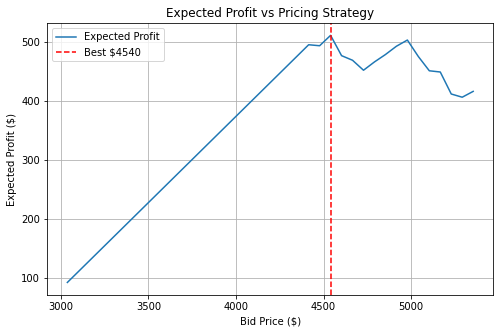

In [26]:
grid, EV_vals, best_price, best_EV, win_probs = optimize_price(
    sample_sqft, sample_cost, cal, scaler, feature_template, min_win_prob=0.15
)

print(f"Sample sqft: {sample_sqft:.0f}")
print(f"Cost: ${sample_cost:.2f}")
print(f"Recommended price: ${best_price:.2f}")
print(f"Expected profit: ${best_EV:.2f}")
print(f"Win probability at best price: {win_probs[np.argmax(EV_vals)]:.2f}")

plt.figure(figsize=(8,5))
plt.plot(grid, EV_vals, label="Expected Profit")
plt.axvline(best_price, linestyle="--", color="red", label=f"Best ${best_price:.0f}")
plt.xlabel("Bid Price ($)")
plt.ylabel("Expected Profit ($)")
plt.title("Expected Profit vs Pricing Strategy")
plt.legend()
plt.grid(True)
plt.show()

### Price Optimization Results

A smooth Expected Profit (EV) curve typically rises sharply as bid prices increase above cost, peaking around a balanced trade-off point where profit and win probability align. Beyond this peak, expected profit declines as higher prices sharply reduce the likelihood of winning.

In this run, the optimizer selected a large 30,000 sqft facility. Such high-square-footage jobs are more competitive and price-sensitive, which naturally lowers the win probability.

At the optimal bid price of \$4,540, the model estimates an expected profit of $511 with a 28% chance of winning.
This result reflects a realistic trade-off for large commercial bids — fewer wins at higher prices, but each win contributes substantial profit.

From a previous run below with a mid-sized 11,500 sqft job,
the model identified an optimal bid price of \$1,450, yielding an expected profit of $307 and a 50% win probability.
This case represents a balanced equilibrium between profitability and competitiveness — smaller jobs tend to have higher win rates but lower per-contract margins.

Together, these examples illustrate how the model adapts pricing recommendations to job scale and competitiveness, producing realistic and interpretable strategies across different bid contexts.

Sample sqft: 11540
Cost: $829.92
Recommended price: $1448.63
Expected profit: $306.95
Win probability at best price: 0.50


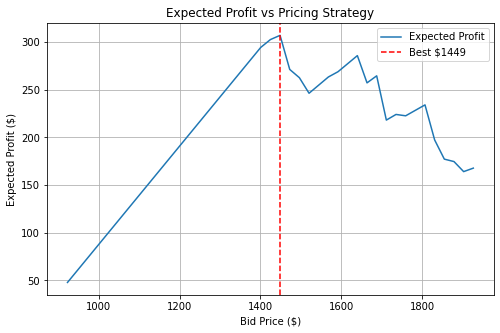

In [49]:
grid, EV_vals, best_price, best_EV, win_probs = optimize_price(
    sample_sqft, sample_cost, cal, scaler, feature_template, min_win_prob=0.15
)

print(f"Sample sqft: {sample_sqft:.0f}")
print(f"Cost: ${sample_cost:.2f}")
print(f"Recommended price: ${best_price:.2f}")
print(f"Expected profit: ${best_EV:.2f}")
print(f"Win probability at best price: {win_probs[np.argmax(EV_vals)]:.2f}")

plt.figure(figsize=(8,5))
plt.plot(grid, EV_vals, label="Expected Profit")
plt.axvline(best_price, linestyle="--", color="red", label=f"Best ${best_price:.0f}")
plt.xlabel("Bid Price ($)")
plt.ylabel("Expected Profit ($)")
plt.title("Expected Profit vs Pricing Strategy")
plt.legend()
plt.grid(True)
plt.show()

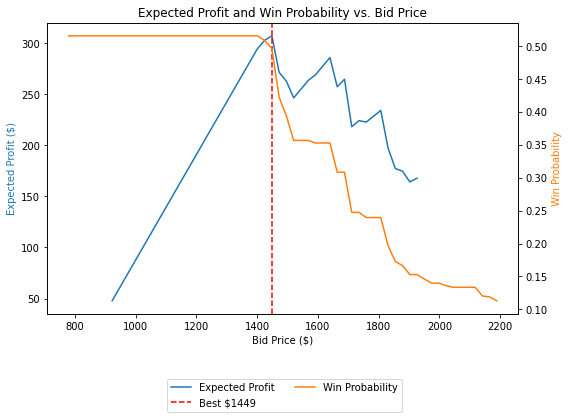

In [50]:
#  11,500 sqft job
fig, ax1 = plt.subplots(figsize=(8,5))

ax1.plot(grid, EV_vals, color='tab:blue', label='Expected Profit')
ax1.set_xlabel("Bid Price ($)")
ax1.set_ylabel("Expected Profit ($)", color='tab:blue')

ax2 = ax1.twinx()
ax2.plot(grid, win_probs, color='tab:orange', label='Win Probability')
ax2.set_ylabel("Win Probability", color='tab:orange')

ax1.axvline(best_price, linestyle="--", color="red", label=f"Best ${best_price:.0f}")
ax1.set_title("Expected Profit and Win Probability vs. Bid Price")

fig.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=2)
fig.tight_layout()
plt.savefig("docs/EVprob.png", dpi=300)
plt.show()

*Note:* The 11,500 sqft example is from a previous run of the same notebook with a different random sample.
Since the dataset is synthetic and re-sampled each time, your results may differ slightly, but the overall trade-offs and curve shapes will remain consistent.

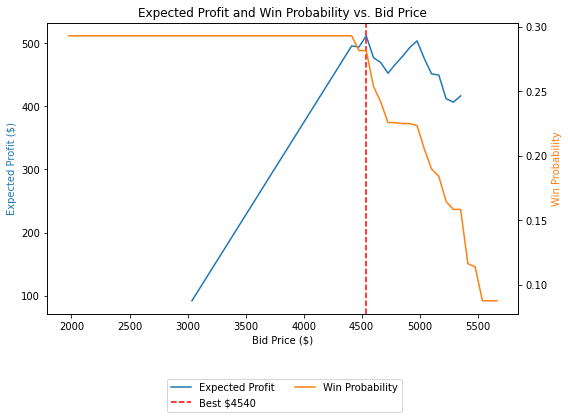

In [27]:
# 30,000 sqft job
fig, ax1 = plt.subplots(figsize=(8,5))

ax1.plot(grid, EV_vals, color='tab:blue', label='Expected Profit')
ax1.set_xlabel("Bid Price ($)")
ax1.set_ylabel("Expected Profit ($)", color='tab:blue')

ax2 = ax1.twinx()
ax2.plot(grid, win_probs, color='tab:orange', label='Win Probability')
ax2.set_ylabel("Win Probability", color='tab:orange')

ax1.axvline(best_price, linestyle="--", color="red", label=f"Best ${best_price:.0f}")
ax1.set_title("Expected Profit and Win Probability vs. Bid Price")

fig.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=2)
fig.tight_layout()
plt.savefig("docs/EVprob.png", dpi=300)
plt.show()

The chart illustrates how expected profit and win probability change with bid price:

- **Blue line (Expected Profit):** rises as profit margin improves, then falls as win probability declines.  
  It stops once the bid price falls below the 10% minimum margin, since those prices are excluded from optimization.
- **Orange line (Win Probability):** decreases smoothly with higher bid prices due to lower competitiveness.
- **Red dashed line:** marks the optimal bid price — the point of maximum expected profit.

This shape reflects the bidding dynamics:
- At very low prices, bids are almost always won but yield minimal profit.  
- At very high prices, profit per job is large but the chance of winning collapses.  
- The optimal point balances both forces — typically yielding moderate profit with a moderate (~50%) win rate.